# CIFAR-100数据集上基于Vision Transformer 实现图片分类

作者信息：[GuoQuanhao](https://github.com/GuoQuanhao)

更新日期：2023 年 02 月 09 日

摘要: 本示例教程演示如何在CIFAR-100数据集上用ViT进行图像分类。

## 一、简要介绍
![](https://ai-studio-static-online.cdn.bcebos.com/063de5fc4b814ad6bfd976320f7c7cc9ca06b38744b1458189ae3a7356f3ffd4)
[ViT](https://arxiv.org/abs/2010.11929)就是**Vi**sion **T**ransformer。在NLP中，输入Transformer中的是一个序列，而在视觉领域中，需要考虑如何将2D的图片转化成1D的序列。ViT尽量保持NLP中Transformer结构，做尽量小的结构或代码调整，主要目的是证明NLP中的Transformer能够很好的迁移到视觉任务上。下述步骤简要阐述了ViT的实现流程：

- 使用图像切片的方式将图片转变成一组Patch得到一个序列；

- 将这一序列Patch通过线性投影层(Patch Embedding)将每一个Patch转变成一个向量(token)；

- 由于每个Patch在图像中具有位置信息，因此为每个token增加位置编码(Position Embedding)，这样每个token既包含了图像块原本有的图像信息，又包含了图像块所在的位置信息。此外，额外添加一个分类字符(Extra learnable class embedding, 借鉴NLP领域)，将分类字符的输出作为最终的分类判断【作者发现采用class embedding和采用global average pooling得到的结果区别不大】；

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/fa28e4e7aa644bc9a801ba746b9e8512efbe30e5e8ba44b0b0ce9999e1141773" width="600"/></center>

- 得到了一个一个的token，将整个序列输入进Transformer，得到反馈的输出；

## 二、环境配置
本教程基于PaddlePaddle 2.4.1 编写，如果你的环境低于本版本，请先参考[官网](https://www.paddlepaddle.org.cn/install/quick?docurl=/documentation/docs/zh/install/install_NGC_PaddlePaddle_ch.html)安装PaddlePaddle最新版本。

In [1]:
import paddle
import time
import paddle.nn as nn
import paddle.nn.functional as F
import paddle.vision.transforms as transforms
from paddle.io import DataLoader
import numpy as np
import paddle.optimizer.lr as lrScheduler
from paddle.vision.transforms import BaseTransform
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import os

paddle.seed(1024)
np.random.seed(1234)

print(paddle.__version__)

2.4.1


## 三、加载数据集
本案例将会使用飞桨提供的API完成数据集的下载，并为后续的训练任务准备好数据迭代器。CIFAR-100数据集有100个类。每个类有600张大小为$32\times 32$的彩色图像，其中500张作为训练集，100张作为测试集。

以下代码块构建了训练阶段和测试阶段的数据增强，`transforms_list`包含了部分PaddlePaddle提供的[数据增强Api](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/vision/transforms/BrightnessTransform_cn.html)，并通过`AutoTransforms`实现随机数据增强。

In [2]:
class AutoTransforms(BaseTransform):
    def __init__(self, transforms=None, keys=None):
        super(AutoTransforms, self).__init__(keys)
        self.transforms = transforms

    def _apply_image(self, image):
        if self.transforms is None: 
            return image
        choose=np.random.randint(0, len(self.transforms))
        return self.transforms[choose](image)

# 训练集数据增强
mean = [0.5071, 0.4867, 0.4408]
std = [0.2675, 0.2565, 0.2761]

transforms_list= [
    transforms.BrightnessTransform(0.5),
    transforms.SaturationTransform(0.5),
    transforms.ContrastTransform(0.5),
    transforms.HueTransform(0.5),
    transforms.RandomRotation(15,
                              expand=True,
                              fill=128),
    transforms.ColorJitter(0.5,0.5,0.5,0.5),
    transforms.Grayscale(3)
]

train_tx = transforms.Compose([
           transforms.RandomHorizontalFlip(),
           AutoTransforms(transforms_list),
           transforms.RandomCrop(32),
           transforms.RandomVerticalFlip(),
           transforms.Transpose(),
           transforms.Normalize(0.0, 255.0),
           transforms.Normalize(mean, std)
])

val_tx = transforms.Compose([
         transforms.Transpose(),
         transforms.Normalize(0.0, 255.0),
         transforms.Normalize(mean, std)
])

cifar100_train = paddle.vision.datasets.Cifar100(mode='train', transform=train_tx, download=True)
cifar100_test = paddle.vision.datasets.Cifar100(mode='test', transform=val_tx, download=True)

print('训练集数量:', len(cifar100_train), '训练集图像尺寸', cifar100_train[0][0].shape)
print('测试集数量:', len(cifar100_test), '测试集图像尺寸', cifar100_test[0][0].shape)

训练集数量: 50000 训练集图像尺寸 (3, 32, 32)
测试集数量: 10000 测试集图像尺寸 (3, 32, 32)


显示训练集和测试集的图像，其中训练集图像包含数据增强后的图像。

In [3]:
def anti_normalize(image):
    image = paddle.to_tensor(image)
    t_mean = paddle.to_tensor(mean).reshape([3, 1, 1]).expand([3, 32, 32])
    t_std = paddle.to_tensor(std).reshape([3, 1, 1]).expand([3, 32, 32])
    return (image * t_std + t_mean).transpose([1, 2, 0])

def plot_num_images(num, data):
    if num < 1:
        print('INFO:The number of input pictures must be greater than zero!')
    else:
        choose_list = []
        for i in range(num):
            choose_n = np.random.randint(len(data))
            choose_list.append(choose_n)
        fig = plt.gcf()
        fig.set_size_inches(10, 10)
        for i in range(num):
            ax_img = plt.subplot(math.ceil(num / int(math.sqrt(num))), int(math.sqrt(num)), i + 1)
            single_data = data[choose_list[i]]
            plt_img = anti_normalize(single_data[0])
            ax_img.imshow(plt_img, cmap='binary')
            ax_img.set_title('label:' + str(single_data[1]),
                             fontsize=10)
            ax_img.axis('off')
        plt.show()

训练集图片可视化。

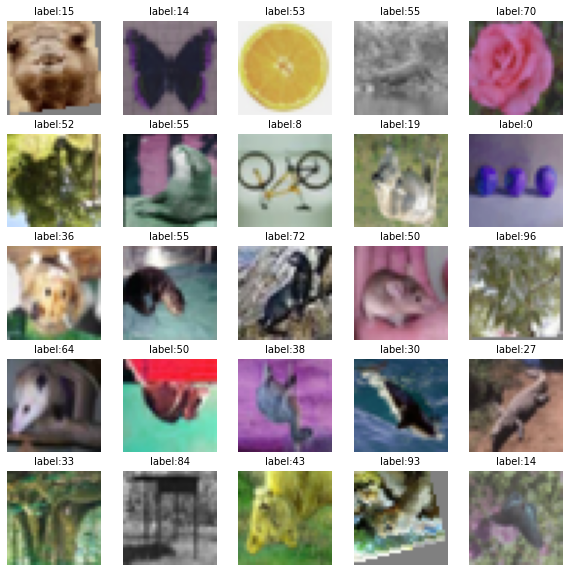

In [4]:
plot_num_images(25, cifar100_train)

测试集图片可视化。

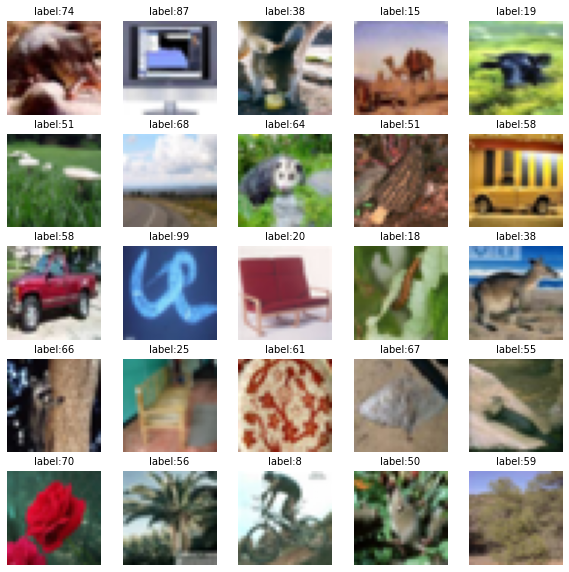

In [5]:
plot_num_images(25, cifar100_test)

## 四、模型组网

ViT模型组网部分包含图像切片(Patches)，多层感知机(MLP)，多头自注意力机制(MultiHeadSelfAttention)以及Transformer编码器(Transformer Encoder)。

### 4.1 Patches
Patches的目的是实现图像切块，将整张图像分割成一个个小块（patch），以方便后续将图像编码成一个个tokens。

In [6]:
class Patches(paddle.nn.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def forward(self, images):
        patches = F.unfold(images, self.patch_size, self.patch_size)
        return patches.transpose([0,2,1])

可视化产生的image patches

Image size: 32 X 32
Patch size: 8 X 8
Patches per image: 16
Elements per patch: 192


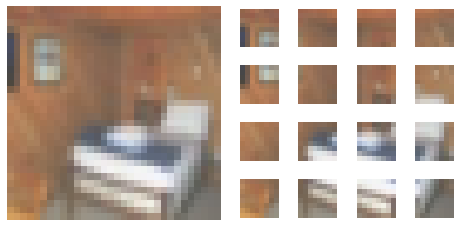

In [7]:
image_size = 32
patch_size = 8

image = anti_normalize(paddle.to_tensor(cifar100_test[np.random.choice(len(cifar100_test))][0]))
fig=plt.figure(figsize=(8, 4))
grid = plt.GridSpec(4, 8, wspace=0.5, figure=fig)
plt.subplot(grid[:4, :4])
plt.imshow(image)
plt.axis("off")

patches = Patches(patch_size)(image.transpose([2, 0, 1]).unsqueeze(0))

print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

for i, patch in enumerate(patches[0]):
    plt.subplot(grid[i // 4, i % 4 + 4])
    patch_img = patch.reshape([3, patch_size, patch_size]).transpose([1,2,0])
    plt.imshow(patch_img)
    plt.axis("off")

### 4.2 MLP

多层感知机包含线性层，激活层(GELU)，DropOut层。线性层将输入扩增指定维度，再缩减回去，MLP不改变输入输出维度。

In [8]:
class Mlp(nn.Layer):
    def __init__(self, feats, mlp_hidden, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(feats, mlp_hidden)
        self.fc2 = nn.Linear(mlp_hidden, feats)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)

        return x

### 4.3 Multi-Head Self Attention(MSA)

多头自注意力机制。每个token的维度是768，假如设置12个头，每个头的维度为$768/12=64$，得到$Q,K,V=197×64$维度。最后将12个头的输出拼接起来最后得到$197×768$维度。论文发现MSA在网络刚开始时就能注意到全局上的信息，而不像CNN一样在浅层部分的感受野非常小。此外，在网络的深层部分，MSA的距离可以非常远，能够学到带有语义性的概念，而不像CNN一样靠临近的像素点去获取语义信息。
<center class="half"><img src=https://ai-studio-static-online.cdn.bcebos.com/8129768a52b04f898d9115ca39a384e8fea7e26dd9f94cf5bd2411a1ad0553c1 width="400"/><img src=https://ai-studio-static-online.cdn.bcebos.com/d61d6660198243a1afc4027b0ac3a7446864458b8fc149ecb8861ffd6fa1dd70 width="200"/> </center>

In [9]:
class MultiHeadSelfAttention(nn.Layer):
    def __init__(self, feats, head=8, dropout=0., attn_dropout=0.0):
        super(MultiHeadSelfAttention, self).__init__()
        self.head = head
        self.feats = feats
        self.sqrt_d = self.feats ** 0.5
        self.qkv = nn.Linear(feats,
                             feats * 3)
        self.out = nn.Linear(feats, feats)
        self.dropout = nn.Dropout(dropout)
        self.attn_dropout = nn.Dropout(attn_dropout)

    def transpose_multi_head(self, x):
        new_shape = x.shape[:-1] + [self.head, self.feats//self.head]
        x = x.reshape(new_shape)
        x = x.transpose([0, 2, 1, 3])
        return x

    def forward(self, x):
        b, n, f = x.shape
        qkv = self.qkv(x).chunk(3, -1)
        q, k, v = map(self.transpose_multi_head, qkv)
        attn = F.softmax(paddle.einsum("bhif, bhjf->bhij", q, k) / self.sqrt_d, axis=-1)
        attn = self.attn_dropout(attn)
        attn = paddle.einsum("bhij, bhjf->bihf", attn, v)
        out = self.dropout(self.out(attn.flatten(2)))
        return out

### 4.4 Transformer Encoder

一个Transformer Encoder包括LayerNorm层，MultiHeadSelfAttention以及MLP，将输入进来的token编码输出。

In [10]:
class TransformerEncoder(nn.Layer):
    def __init__(self, feats, mlp_hidden, head=8, dropout=0., attn_dropout=0.):
        super(TransformerEncoder, self).__init__()
        self.layer1 = nn.LayerNorm(feats)
        self.msa = MultiHeadSelfAttention(feats, head=head, dropout=dropout, attn_dropout=attn_dropout)
        self.layer2 = nn.LayerNorm(feats)
        self.mlp = Mlp(feats, mlp_hidden)

    def forward(self, x):
        out = self.msa(self.layer1(x)) + x
        out = self.mlp(self.layer2(out)) + out
        return out

### 4.5 ViT
将Patches，MLP，MultiHeadSelfAttention以及TransformerEncoder组合，实现ViT。

In [11]:
class ViT(nn.Layer):
    def __init__(self, in_c=3, num_classes=10, img_size=32, patch=8, dropout=0., attn_dropout=0.0, num_layers=7, hidden=384, mlp_hidden=384*4, head=8, is_cls_token=True):
        super(ViT, self).__init__()
        self.patch = patch
        self.is_cls_token = is_cls_token
        self.patch_size = img_size // self.patch
        self.patches = Patches(self.patch_size)
        f = (img_size // self.patch) ** 2 * 3
        num_tokens = (self.patch ** 2) + 1 if self.is_cls_token else (self.patch ** 2)

        self.emb = nn.Linear(f, hidden)
        self.cls_token  = paddle.create_parameter(
            shape = [1, 1, hidden],
            dtype = 'float32',
            default_initializer=nn.initializer.Assign(paddle.randn([1, 1, hidden]))
        ) if is_cls_token else None

        self.pos_embedding  = paddle.create_parameter(
            shape = [1,num_tokens, hidden],
            dtype = 'float32',
            default_initializer=nn.initializer.Assign(paddle.randn([1,num_tokens, hidden]))
        )

        encoder_list = [TransformerEncoder(hidden, mlp_hidden=mlp_hidden, dropout=dropout, attn_dropout=attn_dropout, head=head) for _ in range(num_layers)]
        self.encoder = nn.Sequential(*encoder_list)
        self.fc = nn.Sequential(
            nn.LayerNorm(hidden),
            nn.Linear(hidden, num_classes) # for cls_token
        )

    def forward(self, x):
        out = self.patches(x)
        out = self.emb(out)
        if self.is_cls_token:
            out = paddle.concat([self.cls_token.tile([out.shape[0],1,1]), out], axis=1)
        out = out + self.pos_embedding
        out = self.encoder(out)
        if self.is_cls_token:
            out = out[:,0]
        else:
            out = out.mean(1)
        out = self.fc(out)
        return out

## 五、Slover构建
为了取得更好的效果，构建LabelSmoothingCrossEntropyLoss作为损失函数，并采用[LinearWarmup](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/optimizer/lr/LinearWarmup_cn.html#linearwarmup)和[CosineAnnealingDecay](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/optimizer/lr/CosineAnnealingDecay_cn.html#cosineannealingdecay)构建带有Warmup的Cosine学习率衰减方式。

In [12]:
class LabelSmoothingCrossEntropyLoss(nn.Layer):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingCrossEntropyLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = F.log_softmax(pred, axis=self.dim)
        with paddle.no_grad():
            true_dist = paddle.ones_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.put_along_axis_(target.unsqueeze(1), self.confidence, 1)
        return paddle.mean(paddle.sum(-true_dist * pred, axis=self.dim))

def get_scheduler(epochs, warmup_epochs, learning_rate):
    base_scheduler = lrScheduler.CosineAnnealingDecay(learning_rate=learning_rate, T_max=epochs, eta_min=1e-5, verbose=False)
    scheduler = lrScheduler.LinearWarmup(base_scheduler, warmup_epochs, 1e-5, learning_rate, last_epoch=-1, verbose=False)
    return scheduler

验证衰减方式是否正确。

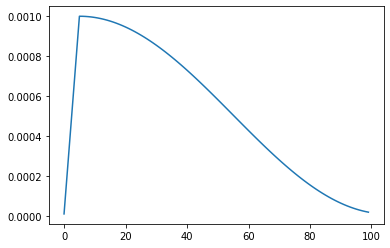

In [13]:
schedulerTest = get_scheduler(epochs=100, warmup_epochs=5, learning_rate=1e-3)
lr = []
for epoch in range(100):
    lr.append(schedulerTest.get_lr())
    schedulerTest.step()
plt.plot(lr)
plt.show()

## 六、模型训练

在训练之前可以通过[paddle.summary](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/summary_cn.html#summary)查验模型。

In [14]:
Model = ViT(in_c=3, num_classes=100, img_size=32, patch=8, dropout=0.5, attn_dropout=0.1, num_layers=7, hidden=384, head=12, mlp_hidden=384, is_cls_token=True)
paddle.summary(Model, (1, 3, 32, 32))

------------------------------------------------------------------------------------
      Layer (type)           Input Shape          Output Shape         Param #    
       Patches-2           [[1, 3, 32, 32]]       [1, 64, 48]             0       
        Linear-1            [[1, 64, 48]]         [1, 64, 384]         18,816     
      LayerNorm-1           [[1, 65, 384]]        [1, 65, 384]           768      
        Linear-2            [[1, 65, 384]]       [1, 65, 1152]         443,520    
       Dropout-2          [[1, 12, 65, 65]]     [1, 12, 65, 65]           0       
        Linear-3            [[1, 65, 384]]        [1, 65, 384]         147,840    
       Dropout-1            [[1, 65, 384]]        [1, 65, 384]            0       
MultiHeadSelfAttention-1    [[1, 65, 384]]        [1, 65, 384]            0       
      LayerNorm-2           [[1, 65, 384]]        [1, 65, 384]           768      
        Linear-4            [[1, 65, 384]]        [1, 65, 384]         147,840    
  

{'total_params': 6278116, 'trainable_params': 6278116}

In [15]:
# hyperparameter
EPOCHS = 200
BATCH_SIZE = 128
NUM_CLASSES = 100
WARMUP_EPOCHS = 5
LR = 1e-3

scheduler = get_scheduler(epochs=EPOCHS, warmup_epochs=WARMUP_EPOCHS, learning_rate=LR)
optim = paddle.optimizer.Adam(learning_rate=scheduler, parameters=Model.parameters(), weight_decay=5e-5)
criterion = LabelSmoothingCrossEntropyLoss(NUM_CLASSES, smoothing=0.1)

train_loader = DataLoader(cifar100_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(cifar100_test, batch_size=BATCH_SIZE * 16, shuffle=False, num_workers=0, drop_last=False)

In [16]:
def train_epoch(model):
    acc_num = 0
    total_samples = 0
    nb = len(train_loader)
    pbar = enumerate(train_loader)
    pbar = tqdm(pbar, total=nb, colour='red')
    pbar.set_description(f'EPOCH: {epoch:3d}')
    for _, (_, data) in enumerate(pbar):
        x_data = data[0]
        y_data = data[1]
        predicts = model(x_data)
        loss = criterion(predicts, y_data)
        loss_item = loss.item()
        acc_num += paddle.sum(predicts.argmax(1) == y_data).item()
        total_samples += y_data.shape[0]
        total_acc = acc_num / total_samples
        current_lr = optim.get_lr()
        loss.backward()
        pbar.set_postfix(train_loss=f'{loss_item:5f}', train_acc=f'{total_acc:5f}', train_lr=f'{current_lr:5f}')
        optim.step()
        optim.clear_grad()
    scheduler.step()

@paddle.no_grad()
def validation(model):
    model.eval()
    acc_num = 0
    total_samples = 0
    nb = len(test_loader)
    pbar = enumerate(test_loader)
    pbar = tqdm(pbar, total=nb, colour='green')
    pbar.set_description(f'EVAL')
    for _, (_, data) in enumerate(pbar):
        x_data = data[0]
        y_data = data[1]
        predicts = model(x_data)
        acc_num += paddle.sum(predicts.argmax(1) == y_data).item()
        total_samples += y_data.shape[0]
        batch_acc = paddle.metric.accuracy(predicts, y_data.unsqueeze(1)).item()
        total_acc = acc_num / total_samples
        pbar.set_postfix(eval_batch_acc=f'{batch_acc:4f}', total_acc=f'{total_acc:4f}')

每50轮保存一次模型参数。

In [17]:
start = time.time()
for epoch in range(EPOCHS):
    train_epoch(Model)
    validation(Model)
    if (epoch + 1) % 50 == 0:
        paddle.save(Model.state_dict(), str(epoch + 1) + '.pdparams')
paddle.save(Model.state_dict(), 'finished.pdparams')
end = time.time()
print('Training Cost ', (end-start) / 60, 'minutes')


EVAL: 100%|██████████████████████████████████████████| 5/5 [00:01<00:00,  2.59it/s, eval_batch_acc=0.532080, total_acc=0.520300]

Training Cost  137.73739756345748 minutes


## 七、模型评估
实现TOP1的精度在0.53左右，TOP5的精度在0.73左右。

In [18]:
state_dict = paddle.load('finished.pdparams')
Model.set_state_dict(state_dict)
Model.eval()
top1_num = 0
top5_num = 0
total_samples = 0
nb = len(test_loader)
pbar = enumerate(test_loader)
pbar = tqdm(pbar, total=nb, colour='green')
pbar.set_description(f'EVAL')
with paddle.no_grad():
    for _, (_, data) in enumerate(pbar):
        x_data = data[0]
        y_data = data[1]
        predicts = Model(x_data)
        total_samples += y_data.shape[0]
        top1_num += paddle.metric.accuracy(predicts, y_data.unsqueeze(1), k=1).item() * y_data.shape[0]
        top5_num += paddle.metric.accuracy(predicts, y_data.unsqueeze(1), k=5).item() * y_data.shape[0]
        TOP1 = top1_num / total_samples
        TOP5 = top5_num / total_samples
        pbar.set_postfix(TOP1=f'{TOP1:4f}', TOP5=f'{TOP5:4f}')

EVAL: 100%|█████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s, TOP1=0.520300, TOP5=0.722700]


## 八、模型预测

In [19]:
Model.eval()
data = cifar100_test[np.random.randint(0, len(cifar100_test))]
pred = Model(paddle.to_tensor(data[0]).unsqueeze(0)).argmax(-1).item()
print('预测结果为:', pred, '标签为:', data[1].item())

预测结果为: 53 标签为: 53
